In [61]:
import numpy as np 
import pandas as pd 
import pyreadr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import numpy as np
import json
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# homemade functions and scripts
import model_ae
import utils

# Autoencoder 

In this project, we aim to analyse the brain low-grade gliomas and glioblastomas tumours from TCGA. In this part, we will use an unsupervised approach, autoencoders, to reconstruct the dataset and analyse: 
- the quality of the output reconstruction of the dataset 
- the most important features and characteristics of the latent space, indicative of the data structure
- the genes most contributing to the model

## Loading data and autoencoder model 

The bulk RNA-Seq TCGA data was previously preprocessed. Three data files are available: 
- the expression data `../data/merged_expression.csv` containing the gene expression data
- the sample metadata `../data/merged_samples.rds` containing the available clinical metadata
- the gene annotations `../data/merged_genes.csv` containing gene information, which we will use to get the correspondance between Ensembl id and gene names for clear visualisations. 

The autoencoder model was previously tuned on the expression data. Based on the best parameters identified, the final model was retrained and we saved: the final model and parameters, the latent projections of `X_train`/`X_test` and the output reconstructions of `X_train`/`X_test`. 

We will load the model, latent projections, reconstructions as well as the data files. We will perform the data preparation (scaling and train-test split) again and load the `X_train` and `X_test` with the same parameters as during the model training as to ensure an identical train-test split. 

#### Expression matrix

In [6]:
# loading expression matrix
X = pd.read_csv("../data/merged_expression.csv", index_col=0)
X.head()

,ENSG00000276168.1,ENSG00000263740.2,ENSG00000133048.13,ENSG00000265735.2,ENSG00000202058.1,ENSG00000198695.2,ENSG00000252010.1,ENSG00000198763.3,ENSG00000129824.16,ENSG00000200312.1,...,ENSG00000204851.7,ENSG00000154734.16,ENSG00000164949.8,ENSG00000132465.12,ENSG00000242950.7,ENSG00000263968.2,ENSG00000135218.19,ENSG00000100867.15,ENSG00000253485.2,ENSG00000004848.8
TCGA-HT-7468-01A-11R-2027-07,8.604286,5.563223,7.809334,5.075322,6.060727,15.949436,5.294349,17.023827,13.257817,5.075322,...,9.637190,9.430882,7.854691,5.727468,6.920168,5.912624,7.931828,8.237980,6.638368,6.675950
TCGA-DU-7015-01A-11R-2027-07,8.453606,5.546896,8.858111,5.546896,5.591451,16.920221,5.286967,17.667525,6.386164,5.075322,...,9.944071,8.778698,9.661123,9.055161,5.983611,5.705796,6.206395,8.166694,6.804484,6.071344
TCGA-HT-7601-01A-11R-2090-07,9.694192,5.479652,11.204155,5.596186,5.541698,16.028277,5.075322,17.127280,5.645290,5.075322,...,9.469871,9.993919,10.731195,6.319223,5.996416,5.479652,8.368708,7.778204,7.353568,6.812570
TCGA-DU-A6S7-01A-21R-A32Q-07,8.322266,5.563448,7.701043,5.075322,6.147194,17.479665,5.075322,18.113888,5.671750,5.075322,...,10.426091,9.112219,10.194877,5.563448,6.147194,6.221050,6.704041,9.823169,11.942656,6.818724
TCGA-IK-7675-01A-11R-2090-07,8.279067,5.604416,8.531655,5.450490,5.755886,16.774909,5.450490,17.546353,9.459408,5.075322,...,9.429267,8.303989,10.715684,6.354291,6.546661,5.721549,6.722158,7.784506,6.843659,8.389566


Our input expression matrix shows samples x genes and contains the expression of the 2000 most highly variable genes, as selected during feature selection. It is ready for feeding into our entoencoder. 

In [7]:
# setting label y as sample name
y = X.index
y

Index(['TCGA-HT-7468-01A-11R-2027-07', 'TCGA-DU-7015-01A-11R-2027-07',
       'TCGA-HT-7601-01A-11R-2090-07', 'TCGA-DU-A6S7-01A-21R-A32Q-07',
       'TCGA-IK-7675-01A-11R-2090-07', 'TCGA-E1-A7YE-01A-11R-A34F-07',
       'TCGA-HT-8107-01A-13R-2404-07', 'TCGA-HT-7467-01A-11R-2027-07',
       'TCGA-DU-8164-01A-11R-2256-07', 'TCGA-TQ-A7RF-01A-11R-A33Z-07',
       ...
       'TCGA-06-2563-01A-01R-A96S-41', 'TCGA-06-0158-01A-01R-A96R-41',
       'TCGA-06-0158-01A-01R-1849-01', 'TCGA-27-1837-01A-01R-1850-01',
       'TCGA-12-3644-01A-01R-A96T-41', 'TCGA-12-0618-01A-01R-A96S-41',
       'TCGA-76-4929-01A-01R-1850-01', 'TCGA-06-6698-01A-11R-A96S-41',
       'TCGA-06-0879-01A-01R-A96S-41', 'TCGA-06-0155-01B-01R-A96R-41'],
      dtype='object', length=925)

In [8]:
# data preparation (scaling and train-test split)
X_train, X_test, y_train, y_test = model_ae.load_data() 
print(X_train.shape)
print(X_test.shape)

(740, 2000)
(185, 2000)


In [9]:
# storing X_train and X_test as dataframes to retrieve row and column names
X_train_df = pd.DataFrame(X_train, 
                        columns=X.columns,
                        index=y_train)
X_train_df.head()

X_test_df = pd.DataFrame(X_test, 
                        columns=X.columns,
                        index=y_test)
X_test_df.head()

,ENSG00000276168.1,ENSG00000263740.2,ENSG00000133048.13,ENSG00000265735.2,ENSG00000202058.1,ENSG00000198695.2,ENSG00000252010.1,ENSG00000198763.3,ENSG00000129824.16,ENSG00000200312.1,...,ENSG00000204851.7,ENSG00000154734.16,ENSG00000164949.8,ENSG00000132465.12,ENSG00000242950.7,ENSG00000263968.2,ENSG00000135218.19,ENSG00000100867.15,ENSG00000253485.2,ENSG00000004848.8
TCGA-12-3644-01A-01R-A96T-41,2.292896,2.262483,0.307937,2.176809,2.446045,-2.086074,2.725061,-2.046884,-1.397372,2.259117,...,-2.272953,0.951969,0.195749,-0.560007,1.823525,2.729038,0.497824,-0.231536,-0.123874,-0.958357
TCGA-06-0678-11A-32R-A36H-07,-0.039824,-0.498517,0.013251,-0.504801,-0.538465,0.733796,-0.512486,0.699130,0.551252,-0.540502,...,2.366489,2.001783,0.287986,-0.411557,-0.440228,-0.445031,-0.929762,1.400754,0.487086,2.213850
TCGA-HT-7882-01A-11R-2403-07,-0.407931,-0.594093,1.363330,-0.520389,-0.543965,0.274193,-0.481897,0.364993,0.681124,-0.540502,...,-1.491204,2.808186,2.153366,2.749754,-0.722980,-0.621987,3.160648,-0.523543,-0.245500,-1.021957
TCGA-S9-A6TS-01A-12R-A33Z-07,-0.619204,-0.660709,-0.314166,-0.525581,-0.487894,0.675114,-0.556630,0.376971,-1.216888,-0.540502,...,0.892490,-0.877625,-0.267015,-0.563757,-0.783661,-0.598219,-0.501969,-0.465724,-0.592815,0.133027
TCGA-19-4065-01A-01R-2005-01,-0.465509,-0.512048,1.523577,-0.517119,-0.420418,0.412163,-0.478514,0.231296,1.093418,-0.376643,...,-1.389699,0.073877,0.461428,1.813194,-0.849350,-0.620688,0.494213,-1.150250,-1.138375,0.912947


#### Gene annotations and sample metadata

Finally, we load the gene annotations and sample metadata to retrieve gene names from ensembl ids as well as the clinical data we need for results analysis and interpretation. 

In [10]:
# gene annotations
genes = pd.read_csv("../data/merged_genes.csv")
genes.head()

# creating gene map to retrieve gene names from emsembl ids
gene_map = dict(zip(genes["gene_id"], genes["gene_name"])) 

In [ ]:
# sample metadata
meta = pyreadr.read_r("../data/merged_samples.rds")
meta.keys() #checking contents of the OrderedDict object 
samples = meta[None]
samples.head()

In [50]:
# reformatting metadata used for the analysis
print(samples["primary_diagnosis"].value_counts())
samples["primary_diagnosis"] = samples["primary_diagnosis"].replace({"Not Reported": "Unknown"}) # merging Not Reported and Unknown
samples["subtype"] = samples["primary_diagnosis"].replace({"Papillary carcinoma, NOS": "Carcinoma",
                                                           "Basal cell carcinoma, NOS": "Carcinoma",
                                                           "Astrocytoma, NOS": "Astrocytoma",
                                                           "Astrocytoma, anaplastic": "Astrocytoma",
                                                           "Oligodendroglioma, NOS": "Oligodendroglioma",
                                                           "Oligodendroglioma, anaplastic": "Oligodendroglioma"}) # extracting the main tumor subtypes
print(samples["primary_diagnosis"].value_counts())


primary_diagnosis
Glioblastoma                     376
Mixed glioma                     128
Oligodendroglioma, NOS           114
Astrocytoma, anaplastic          110
Oligodendroglioma, anaplastic     73
Astrocytoma, NOS                  58
Unknown                           58
Basal cell carcinoma, NOS          1
Papillary carcinoma, NOS           1
Name: count, dtype: int64
primary_diagnosis
Glioblastoma                     376
Mixed glioma                     128
Oligodendroglioma, NOS           114
Astrocytoma, anaplastic          110
Oligodendroglioma, anaplastic     73
Astrocytoma, NOS                  58
Unknown                           58
Basal cell carcinoma, NOS          1
Papillary carcinoma, NOS           1
Name: count, dtype: int64


In [51]:
# creating map to retrieve tumour type (GBM vs LGG) for each sample in the test set
tumor_map, colors_tumor = utils.create_map(X_test_df, samples, ref_col="sample_id", mapping_col="tumor_type")

# creating map to retrieve tumour grade (G1, G2, G3, G4) for each sample in the test set
grade_map, colors_grade = utils.create_map(X_test_df, samples, ref_col="sample_id", mapping_col="tumor_grade")

# creating map to retrieve tumour subtype (G1, G2, G3, G4) for each sample in the test set
subtype_map, colors_subtype = utils.create_map(X_test_df, samples, ref_col="sample_id", mapping_col="subtype")


#### Model & parameters, latent embeddings and reconstructions

In [ ]:
# load model and parameters
model = load_model("final_model/final_ae.keras")
params = np.load("final_model/final_ae_params.npy", allow_pickle=True).item()

# load latent embeddings
Z_train = np.load("final_model/Z_train.npy")
Z_test  = np.load("final_model/Z_test.npy")

# load reconstructions
X_train_rec = np.load("final_model/X_train_rec.npy")
X_test_rec  = np.load("final_model/X_test_rec.npy")

In [25]:
# storing X_train_rec and X_test_rec as dataframes to retrieve row and column names
X_train_rec_df = pd.DataFrame(X_train_rec, 
                        columns=X.columns,
                        index=y_train)
X_train_rec_df.head()

X_test_rec_df = pd.DataFrame(X_test_rec, 
                        columns=X.columns,
                        index=y_test)
X_test_rec_df.head()

,ENSG00000276168.1,ENSG00000263740.2,ENSG00000133048.13,ENSG00000265735.2,ENSG00000202058.1,ENSG00000198695.2,ENSG00000252010.1,ENSG00000198763.3,ENSG00000129824.16,ENSG00000200312.1,...,ENSG00000204851.7,ENSG00000154734.16,ENSG00000164949.8,ENSG00000132465.12,ENSG00000242950.7,ENSG00000263968.2,ENSG00000135218.19,ENSG00000100867.15,ENSG00000253485.2,ENSG00000004848.8
TCGA-12-3644-01A-01R-A96T-41,2.465721,2.468901,0.508914,2.519710,2.581487,-2.223174,2.521610,-2.208911,-0.653509,2.435153,...,-0.856771,0.814004,0.960617,0.446606,1.326496,3.079979,0.804115,0.087317,1.326314,-0.592314
TCGA-06-0678-11A-32R-A36H-07,-0.515863,-0.612550,0.180688,-0.440780,-0.468665,0.714796,-0.577564,0.911548,0.350216,-0.558154,...,2.706674,0.772098,-0.544214,-0.518130,-0.519807,-0.688562,-0.598072,0.064907,0.666707,2.067579
TCGA-HT-7882-01A-11R-2403-07,-0.290581,-0.531903,1.501755,-0.378909,-0.419629,0.287149,-0.543676,0.570147,1.016231,-0.347694,...,-0.884033,2.342080,1.475557,2.472436,-0.297659,-0.751118,2.085367,-0.745745,-0.383600,-0.250437
TCGA-S9-A6TS-01A-12R-A33Z-07,-0.652455,-0.596501,-0.564614,-0.608153,-0.609280,0.806599,-0.577422,0.736761,-1.253014,-0.593680,...,0.990113,-0.863786,-0.178048,-0.485200,-0.296354,-0.589552,-1.043950,0.076144,-0.034488,0.303159
TCGA-19-4065-01A-01R-2005-01,-0.212054,-0.363839,1.576355,-0.306991,-0.318552,0.274137,-0.548445,0.258124,1.143790,-0.378358,...,-1.322934,1.508649,0.685404,1.031330,-0.653167,-0.609233,0.892740,-0.542100,-0.927459,0.738044


## Comparing the reconstruction of the output to the input data

Firstly, we are interested in understanding how well the autoencoder was able to reconstruct the data. This will enable us to know how much of the data structure the autoencoder was able to identify, which will give us an indication regarding the reliability of our results. 

We start by quantifying reconstruction quality using the mean-squared error (MSE), which compared the average squared deviation between each input and reconstructed observation. Global MSE summarizes overall fit; per-feature MSE shows which variables are harder to reconstruct; per-class MSE reveals whether some species are intrinsically less well captured by the same 2-dimensional bottleneck. Similar train and test MSEs indicate that the model has learned general patterns rather than memorizing the training set.

In [26]:
# global mse 
mse_train = np.mean((X_train_df - X_train_rec_df)**2)
mse_test  = np.mean((X_test_df  - X_test_rec_df )**2)

# per feature mse on test data
mse_per_feature = np.mean((X_test_df - X_test_rec_df)**2, axis=0)

# per sample mse on test data 
mse_per_sample = ((X_test_rec_df - X_test_df)**2).mean(axis=1)

# per type mse on test data (gbm vs lgg)
mse_by_tumor = mse_per_sample.groupby(tumor_map).mean().to_dict()

# per grade mse on test data (G2 vs G3 vs G4)
mse_by_grade = (mse_per_sample.groupby(grade_map).mean().to_dict())

print("Global MSE (train):", mse_train)
print("Global MSE (test):", mse_test)
print("Per-type (LGG vs GBM) MSE (test):", mse_by_tumor)
print("Per-grade (G2 vs G3 vs G4) MSE (test):", mse_by_grade)

Global MSE (train): 0.1709781397103083
Global MSE (test): 0.240251016866592
Per-type (LGG vs GBM) MSE (test): {'GBM': 0.26415661137513863, 'LGG': 0.2243139538608943}
Per-grade (G2 vs G3 vs G4) MSE (test): {'G2': 0.16073196126208736, 'G3': 0.25168245296073616, 'G4': 0.26415661137513863, 'NA': 0.27636340865938447}


C:\Users\themi\AppData\Local\Temp\ipykernel_15144\2693181436.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mse_by_tumor = mse_per_sample.groupby(tumor_map).mean().to_dict()
C:\Users\themi\AppData\Local\Temp\ipykernel_15144\2693181436.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mse_by_grade = (mse_per_sample.groupby(grade_map).mean().to_dict())


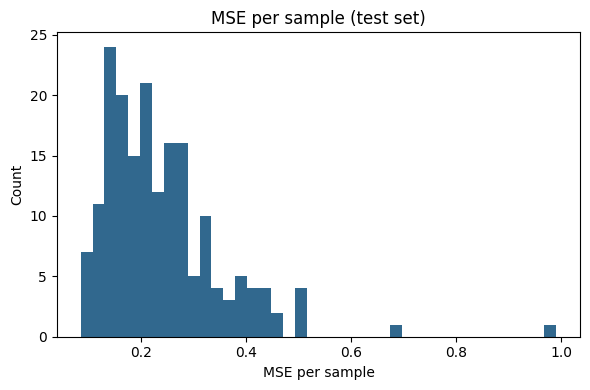

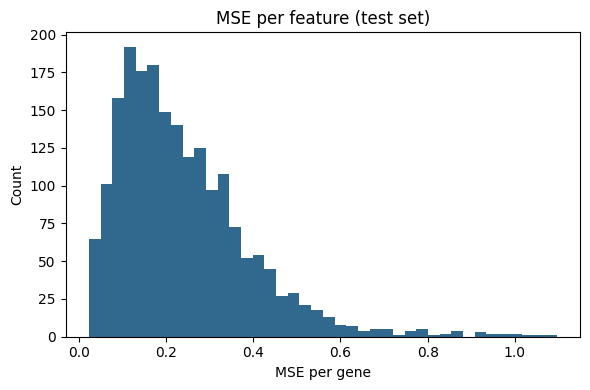

In [27]:
# plotting the mse distribution per sample and per gene 

plt.figure(figsize=(6,4))
plt.hist(mse_per_sample, bins=40, color="#31688E")
plt.xlabel("MSE per sample")
plt.ylabel("Count")
plt.title("MSE per sample (test set)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(mse_per_feature, bins=40, color="#31688E")
plt.xlabel("MSE per gene")
plt.ylabel("Count")
plt.title("MSE per feature (test set)")
plt.tight_layout()
plt.show()


C:\Users\themi\AppData\Local\Temp\ipykernel_15144\3486569879.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["tumor", "grade"])["mse"]


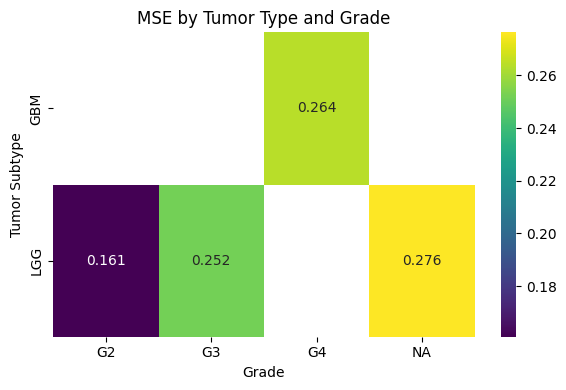

In [ ]:
df = pd.DataFrame({
    "mse": mse_per_sample,
    "tumor": tumor_map.values,
    "grade": grade_map.values,
})
pivot = (
    df.groupby(["tumor", "grade"])["mse"]
      .mean()
      .unstack()       # rows = tumor type, columns = grade
)

plt.figure(figsize=(6,4))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".3f",
    cmap="viridis"
)
plt.title("MSE by Tumor Type and Grade")
plt.ylabel("Tumor Subtype")
plt.xlabel("Grade")
plt.tight_layout()
plt.show()



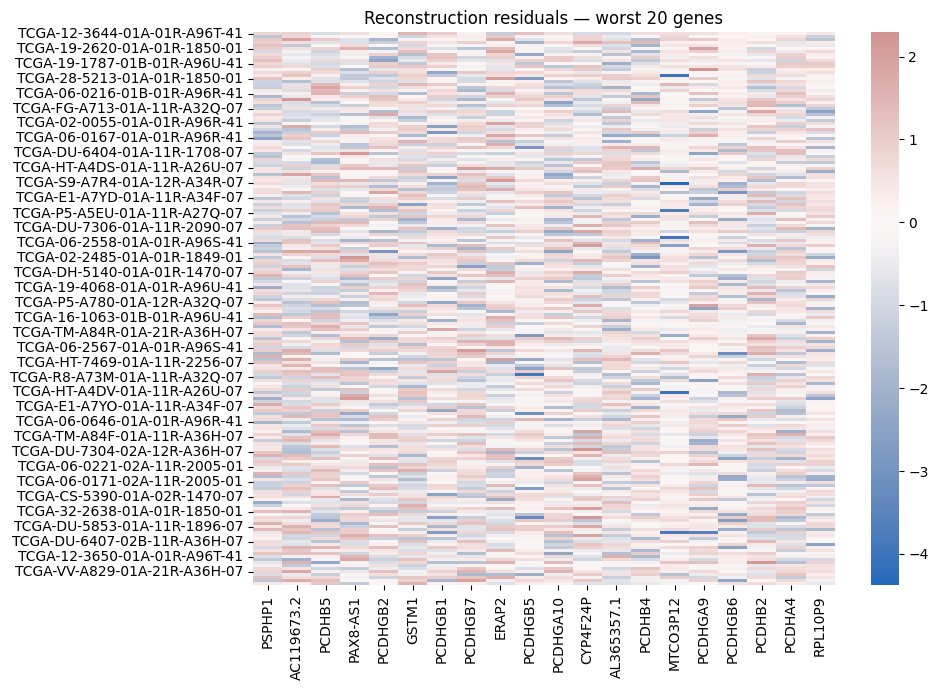

In [29]:
# heatmap of the reconstructed vs input gene counts for the worst genes
worst_genes = mse_per_feature.sort_values(ascending=False).head(20).index
residuals = X_test_rec_df[worst_genes] - X_test_df[worst_genes]

gene_map = dict(zip(genes["gene_id"], genes["gene_name"]))
residuals.columns = [gene_map.get(g, g) for g in residuals.columns]

plt.figure(figsize=(10,7))
sns.heatmap(residuals, cmap="vlag", center=0)
plt.title("Reconstruction residuals — worst 20 genes")
plt.tight_layout()
plt.show()


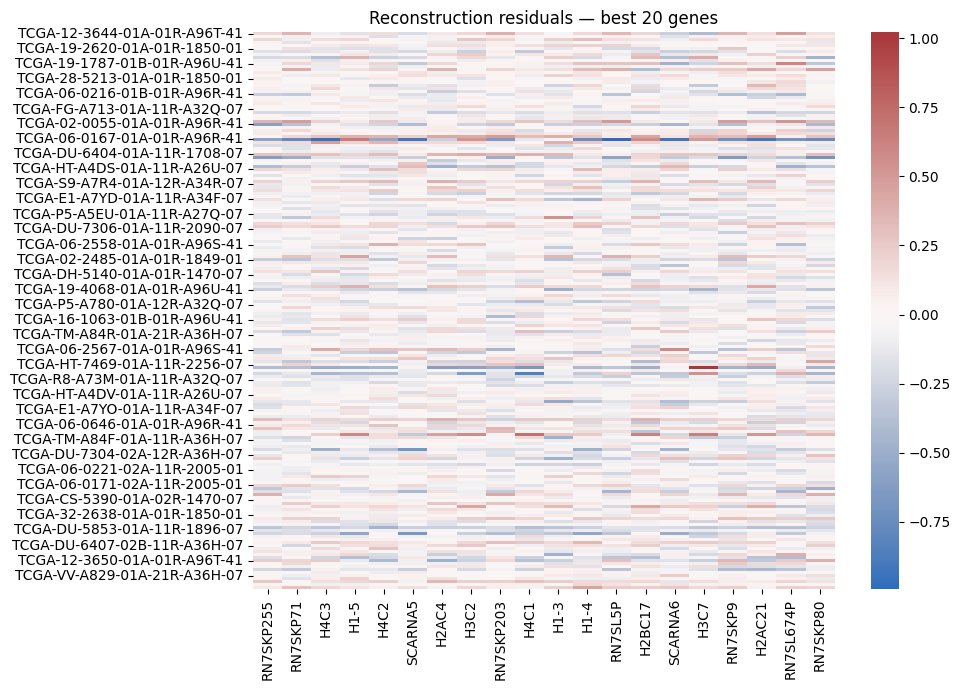

In [30]:
# heatmap of the reconstructed vs input gene counts for the best genes
best_genes = mse_per_feature.sort_values(ascending=True).head(20).index
residuals = X_test_rec_df[best_genes] - X_test_df[best_genes]

gene_map = dict(zip(genes["gene_id"], genes["gene_name"]))
residuals.columns = [gene_map.get(g, g) for g in residuals.columns]

plt.figure(figsize=(10,7))
sns.heatmap(residuals, cmap="vlag", center=0)
plt.title("Reconstruction residuals — best 20 genes")
plt.tight_layout()
plt.show()

## Separate encoder and latent projection

We will now look at the latent embeddings that we extracted from the encoder to map the samples into the 128-latent space. Plotting the test set in this space reveals how the network organizes data without using labels during training. Clusters typically emerge because the model learns a compact geometric arrangement that best supports accurate reconstruction of the standardized inputs.

Since our latent space is high-dimensional (128), we will project the data on a 2D space using three dimensionality reduction methods, PCA (linear), UMAP (non-linear) and t-SNE (linear). We want to see if those three different methods can capture trends in the latent space of our encoder, and investigate their meaningfulness. We will overlay the projection with different clinical characteristics and investigate which of these metadata seem to strongly influence the structure of the data, resulting in a separation in the latent space. 

In [42]:
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\themi\\programming\\aida\\deep_learning\\project\\scripts\\utils.py'>

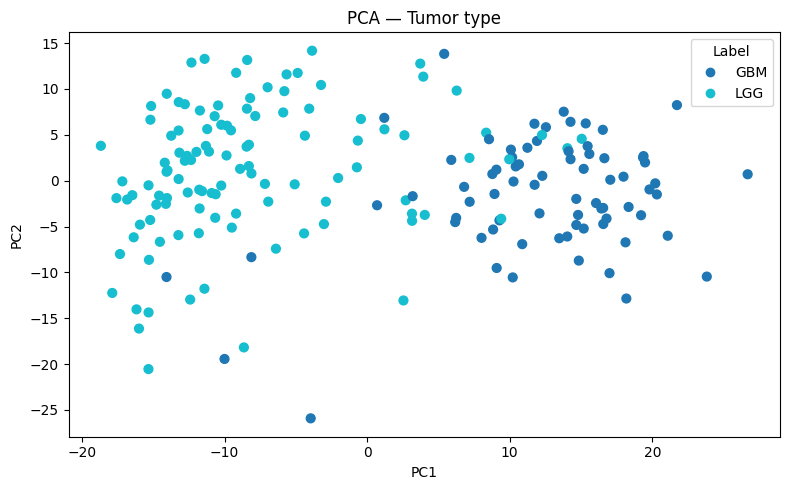

Explained variance ratio: [0.3218442  0.10050425]


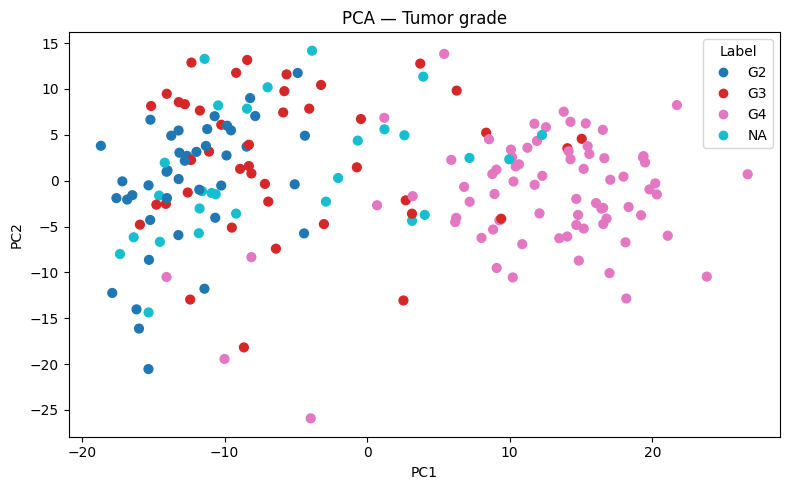

Explained variance ratio: [0.3218442  0.10050425]


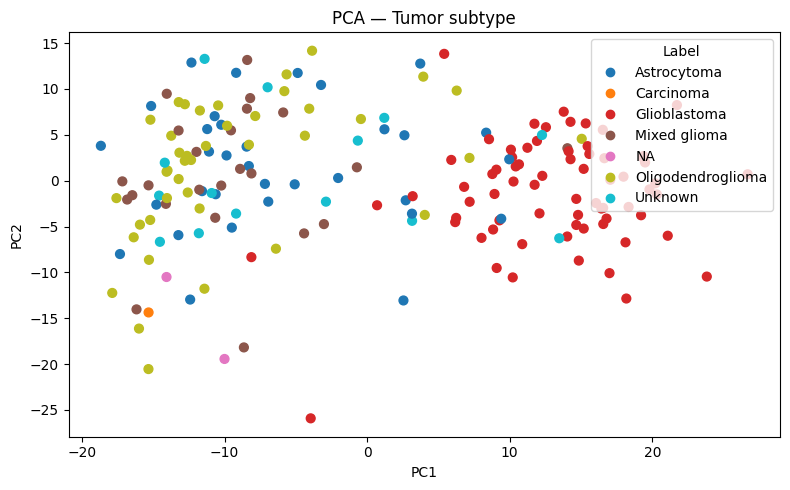

Explained variance ratio: [0.3218442  0.10050425]


(array([[ 16.553411  ,  -2.9740527 ],
        [-10.008703  , -19.439453  ],
        [ 15.0497875 ,   4.5605087 ],
        [-11.583045  ,  -1.1435902 ],
        [ 15.187124  ,   1.2840295 ],
        [  6.2416315 ,  -4.061274  ],
        [ 26.690063  ,   0.69559497],
        [ 11.910414  ,   4.327978  ],
        [  0.6930952 ,  -2.6844034 ],
        [-10.238325  ,  -0.53573436],
        [ 17.053308  ,   0.09768037],
        [-10.659629  ,  -4.0460234 ],
        [ 19.352585  ,   2.514448  ],
        [-11.810503  ,  -5.7334795 ],
        [-14.597017  ,  -1.6315948 ],
        [ 10.419657  ,   1.5500567 ],
        [-16.47672   ,  -1.5866108 ],
        [  8.833504  ,  -5.326182  ],
        [-14.06097   ,   9.470659  ],
        [ -3.8669796 ,  14.16343   ],
        [ 19.2128    ,  -3.771634  ],
        [ -8.302057  ,   1.5918939 ],
        [ -9.554993  ,   5.482826  ],
        [-10.454573  ,   8.19823   ],
        [ -8.915234  ,   1.2826184 ],
        [-15.335977  , -14.368671  ],
        [ -5

In [52]:
# PCA projection 
utils.plot_pca(Z_test, tumor_map, title="PCA — Tumor type")
utils.plot_pca(Z_test, grade_map, title="PCA — Tumor grade")
utils.plot_pca(Z_test, subtype_map, title="PCA — Tumor subtype")

c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


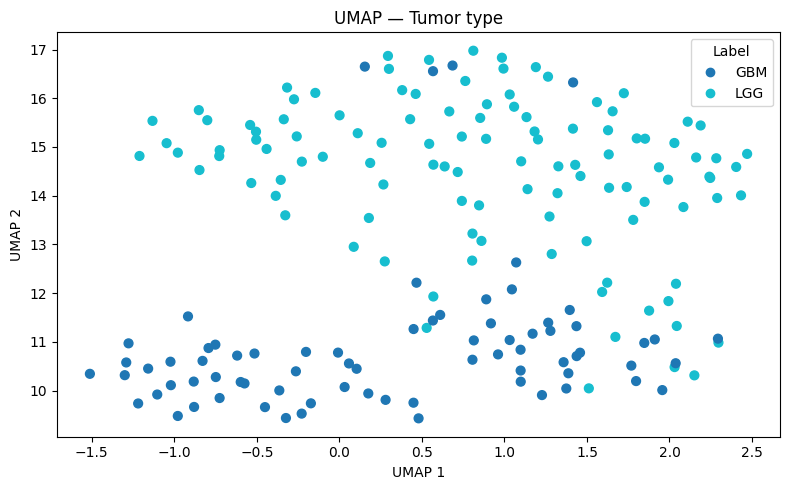

c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


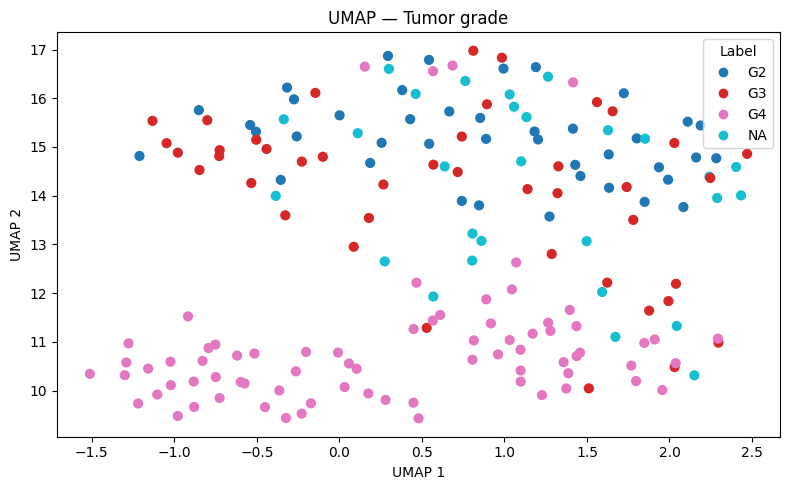

c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


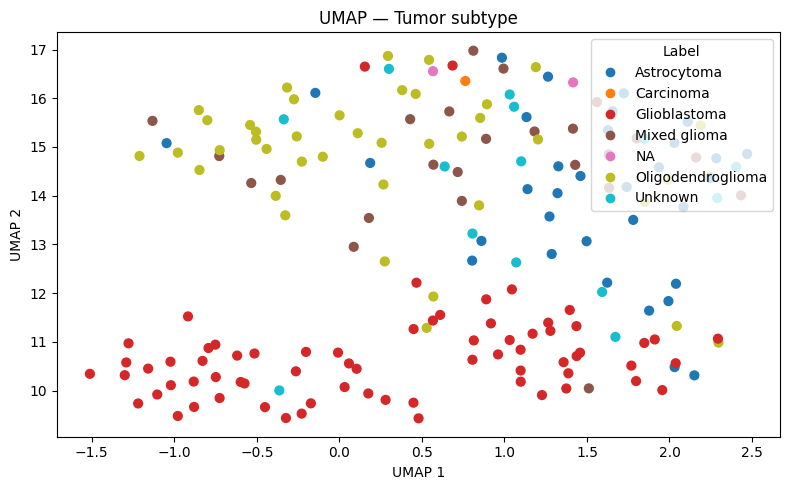

array([[-1.30000353e+00,  1.03161383e+01],
       [ 5.67488551e-01,  1.65555382e+01],
       [ 5.28980494e-01,  1.12866774e+01],
       [ 1.62797391e+00,  1.53434925e+01],
       [ 8.06507230e-01,  1.06332598e+01],
       [ 1.39580774e+00,  1.16543732e+01],
       [ 1.04683578e-01,  1.04477453e+01],
       [ 1.27865875e+00,  1.12257843e+01],
       [-9.16856408e-01,  1.15224171e+01],
       [ 8.89015734e-01,  1.51668081e+01],
       [ 5.83361872e-02,  1.05567188e+01],
       [ 1.18275321e+00,  1.53179512e+01],
       [ 1.43755507e+00,  1.07074547e+01],
       [ 1.03207362e+00,  1.60775070e+01],
       [ 1.05876136e+00,  1.58256016e+01],
       [ 1.26539338e+00,  1.13938236e+01],
       [ 4.28993642e-01,  1.55701466e+01],
       [-1.02306890e+00,  1.05925837e+01],
       [-7.27585495e-01,  1.48137207e+01],
       [-3.85277182e-01,  1.39968815e+01],
       [ 3.20212469e-02,  1.00729246e+01],
       [ 1.32177973e+00,  1.40514622e+01],
       [ 1.63409722e+00,  1.41620092e+01],
       [ 2.

In [60]:
# UMAP projection 
utils.plot_umap(Z_test, tumor_map, title="UMAP — Tumor type")
utils.plot_umap(Z_test, grade_map, title="UMAP — Tumor grade")
utils.plot_umap(Z_test, subtype_map, title="UMAP — Tumor subtype")

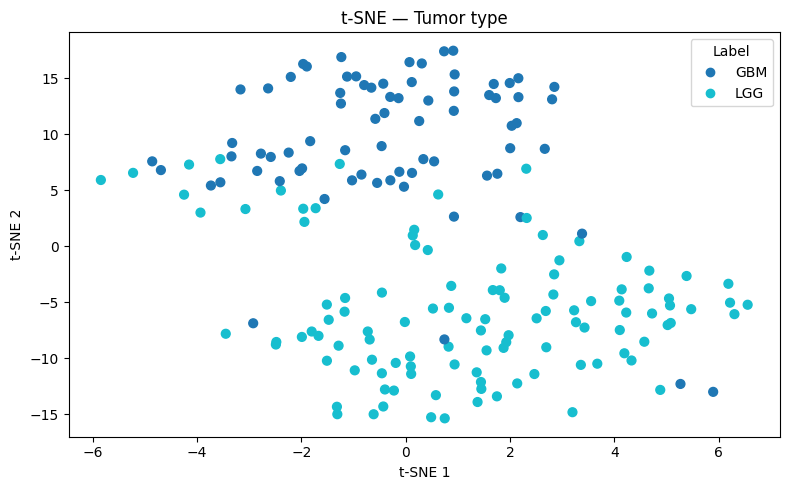

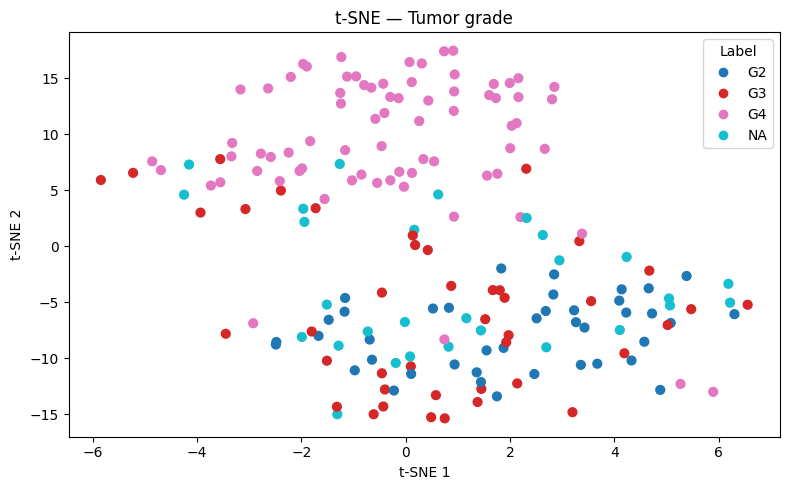

(array([[-1.89603102e+00,  1.60480614e+01],
        [ 5.26641560e+00, -1.22958307e+01],
        [ 2.31053853e+00,  6.92066240e+00],
        [ 1.16277349e+00, -6.42863417e+00],
        [ 3.37885767e-01,  7.77870893e+00],
        [-1.55576622e+00,  4.21723604e+00],
        [ 2.03174257e+00,  1.07568083e+01],
        [-4.62039411e-01,  8.94047928e+00],
        [-3.16701818e+00,  1.39990540e+01],
        [ 5.21940947e-01, -5.56323862e+00],
        [-5.82489550e-01,  1.13744955e+01],
        [ 8.28697085e-01, -5.49614716e+00],
        [-1.83104527e+00,  9.38156605e+00],
        [-1.66056305e-02, -6.76463652e+00],
        [ 2.69433284e+00, -9.02150536e+00],
        [-1.21727683e-01,  6.64706469e+00],
        [ 1.87582624e+00, -9.07582378e+00],
        [-2.20284724e+00,  1.51172991e+01],
        [ 5.78377187e-01, -1.32964134e+01],
        [-1.31080484e+00, -1.49987049e+01],
        [ 1.99372911e+00,  1.45715666e+01],
        [ 1.66960788e+00, -3.91487527e+00],
        [ 4.13950539e+00, -3.850

In [ ]:
# t-SNE projection 
utils.plot_tsne(Z_test, tumor_map, title="t-SNE — Tumor type")
utils.plot_tsne(Z_test, grade_map, title="t-SNE — Tumor grade")
utils.plot_tsne(Z_test, subtype_map, title="t-SNE — Tumor subtype")

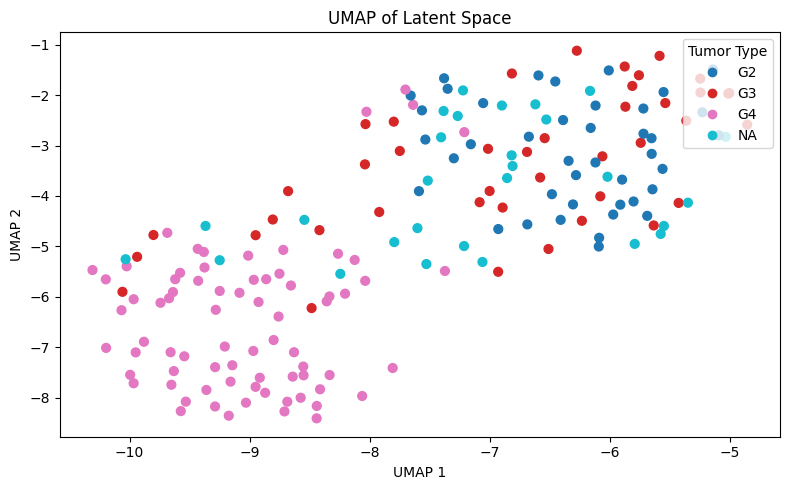

In [33]:
Z_umap = UMAP(n_neighbors=20, min_dist=0.3).fit_transform(Z_test)

# Build a shared colormap + normalization
cmap = plt.cm.tab10
norm = matplotlib.colors.Normalize(vmin=colors_grade.min(), vmax=colors_grade.max())

# Plot using the SAME mapping
plt.figure(figsize=(8,5))
sc = plt.scatter(
    Z_umap[:, 0], Z_umap[:, 1],
    c=colors_grade, cmap=cmap, norm=norm, s=40
)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP of Latent Space")

# Legend using exact category→code mapping
handles = [
    plt.Line2D([], [], marker="o", linestyle="",
               color=cmap(norm(code)), label=label)
    for code, label in enumerate(grade_map.categories)
]

plt.legend(handles=handles, title="Tumor Type", loc="upper right")
plt.tight_layout()
plt.show()


The three dimensionality reduction methods show a similar clustering of observations. While glioblastoma observations (G4) seem to stand out from the low-grade gliomas, it remains hard to isolate the different low-grade gliomas by tumor grade or subtype. 

A simple way to test usefulness of the latent representation is to train a lightweight classifier on it. A k-nearest neighbors (kNN) model on Z provides an immediate sanity check: if the accuracy remains competitive with kNN on the original standardized features, the 2-dimensional code preserves class-relevant structure while being more compact.

In [ ]:
#train knn on latent embeddings using the tumor type as label
label_map = samples.set_index("sample_id")["tumor_type"]
y_train_label = y_train.map(label_map)
y_test_label  = y_test.map(label_map)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Z_train, y_train_label)

#predict test set
knn_pred = knn.predict(Z_test)

accuracy = accuracy_score(y_test_label, knn_pred)
print(f"KNN accuracy on latent space: {accuracy:.3f}")

KNN accuracy on latent space: 0.946


We get a good accuracy of 0.946, suggesting that the latent representation of the autoencoder model is preserving the class-relevant structure. 

## Investigating marker contributions to the model 

We are now interested in understanding which genes seem to contribute most to the model, i.e. to the latent projection of the input through the encoder. Indeed, this could help us identify genes important for the data structure, e.g. differentiation of the cancer classes. 

To that aim, we will use two different methods: 
- the calculation of gradient-based feature importance, i.e. calculate the impact of perturbating one gene on the model's latent space (a high gradient indicates that the gene strongly influences the encoding)
- the calculation of the correlation between each gene and each latent dimension (a gene highly correlated with the first dimension is suggested to strongly influence the encoding)

We will then investigate the biological function and relevance of these identified genes regarding to cancer to uncover some meaningful insights. 

#### Gradient-based feature importance

In [65]:
# gradient-based feature importance 

# extracting encoder
encoder = Model(inputs=model.input, outputs=model.get_layer("latent").output) 

# X_test as tf.Variable
x_var = tf.Variable(tf.convert_to_tensor(X_test, dtype=tf.float32))

with tf.GradientTape() as tape:
    z = encoder(x_var)  # latent outputs

# gradients of latent w.r.t. input features
grads = tape.gradient(z, x_var).numpy()  # shape: (samples, genes)

# aggregate to get feature importance per gene
gene_importance = np.mean(np.abs(grads), axis=0)

# get top 20 genes
top_indices = np.argsort(-gene_importance)[:20]
top20_df = pd.DataFrame({
    "gene_name": [gene_map.get(X_test_df.columns[i], X_test_df.columns[i]) for i in top_indices],
    "feature_importance": gene_importance[top_indices]
})

top20_df


,gene_name,feature_importance
0,GREB1L,0.701872
1,EDNRB,0.674323
2,GOLGA8A,0.589945
3,KLHL4,0.585264
4,CCL3L3,0.561973
5,NRN1,0.553547
6,MT1X,0.552078
7,PCOLCE2,0.546896
8,TUBA4A,0.517729
9,MEG3,0.509891


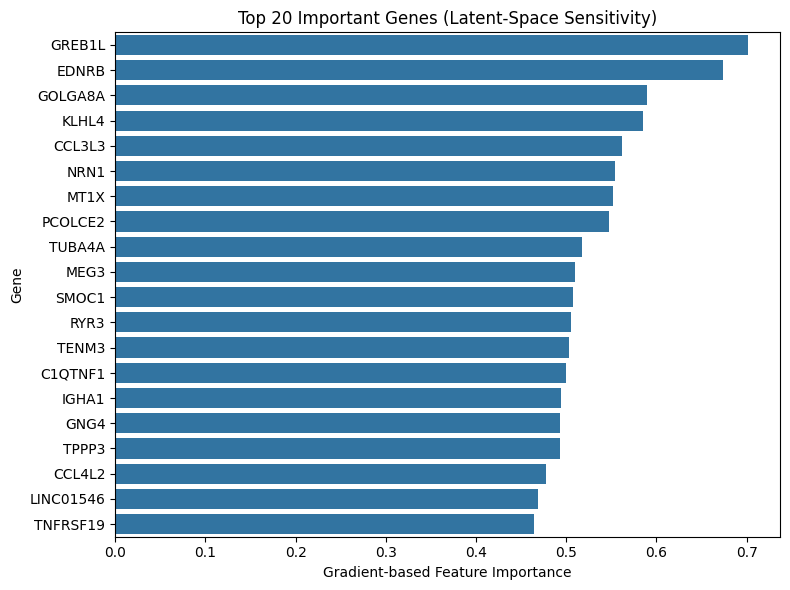

In [77]:
top20_plot = top20_df.copy()
top20_plot = top20_plot.sort_values("feature_importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(
    data=top20_plot,
    x="feature_importance",
    y="gene_name",
    orient="h"
)
plt.xlabel("Gradient-based Feature Importance")
plt.ylabel("Gene")
plt.title("Top 20 Important Genes (Latent-Space Sensitivity)")
plt.tight_layout()
plt.show()


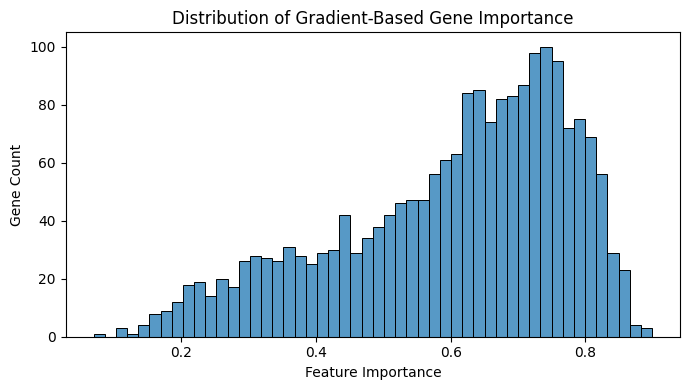

In [78]:
plt.figure(figsize=(7,4))
sns.histplot(gene_importance, bins=50)
plt.xlabel("Feature Importance")
plt.ylabel("Gene Count")
plt.title("Distribution of Gradient-Based Gene Importance")
plt.tight_layout()
plt.show()

#### Correlation with the latent dimensions

In [ ]:
# identifying the dimensions carrying most of the variance (i.e. most informative)
dim_importance = np.var(Z_test, axis=0)
top_dims = np.argsort(-dim_importance)[:10]   # top 10 most informative dims
top_dims 

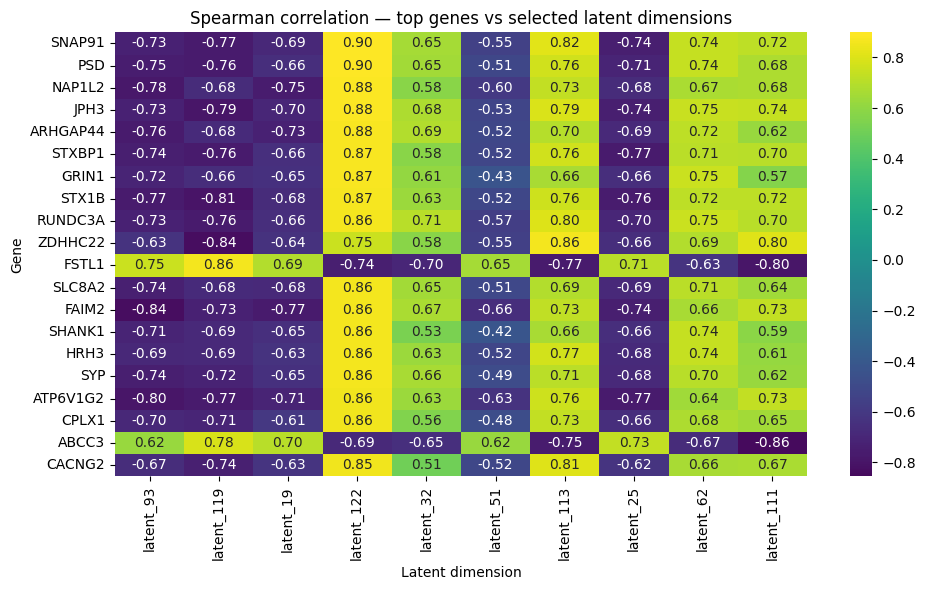

In [69]:
# computing correlations for selected dims 
corr = np.zeros((len(top_dims), X_test.shape[1]))

for i, k in enumerate(top_dims):
    for g in range(X_test.shape[1]):
        corr[i, g] = st.spearmanr(Z_test[:, k], X_test[:, g])[0]

# dims as columns, genes as rows
corr_df = pd.DataFrame(
    corr.T,
    index=X_test_df.columns,
    columns=[f"latent_{k+1}" for k in top_dims]
)

# ---- pick top-20 genes (by max |correlation| across subset dims) ----
gene_importance = corr_df.abs().max(axis=1)
top_genes = gene_importance.sort_values(ascending=False).head(20).index

corr_top = corr_df.loc[top_genes]
corr_top.index = [gene_map.get(i, i) for i in corr_top.index]

# ---- heatmap ----
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_top,
    cmap="viridis",
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title("Spearman correlation — top genes vs selected latent dimensions")
plt.xlabel("Latent dimension")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


## PCA comparison 

PCA provides a linear reference. By projecting the standardized data into its first two principal components, we can compare what a linear method preserves versus what the non-linear autoencoder emphasizes. Differences between the two views indicate where non-linear structure helps organize the data for reconstruction.

In [70]:
# scaling whole data 
dat_scaled = StandardScaler().fit_transform(X)
X = pd.DataFrame(dat_scaled, 
                columns=X.columns,
                index=X.index)
X.head()

pca = PCA(n_components=2)
Z = pca.fit_transform(X)

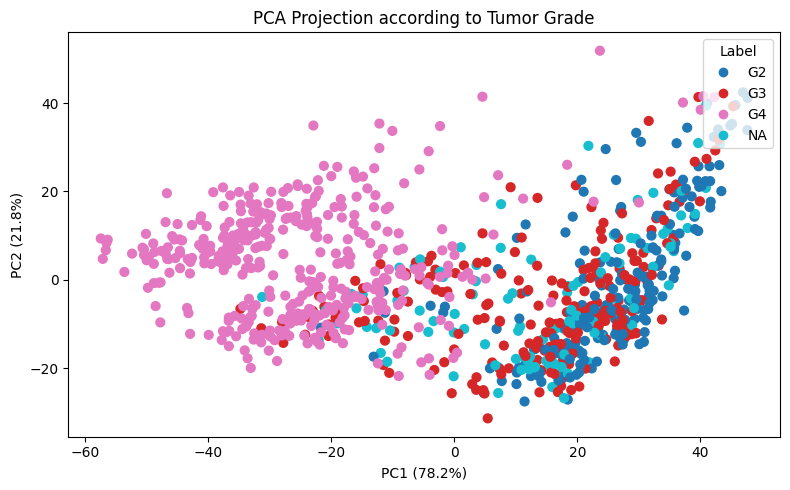

Explained variance ratio: [0.78193304 0.21806696]


In [ ]:
# Map y_test -> tumor_grade
map_tumor = samples.set_index("sample_id")["tumor_grade"]
tumor_for_test = pd.Series(y).map(map_tumor).fillna("NA")

# Convert to categorical codes
tumor_cat = tumor_for_test.astype("category")
colors = tumor_cat.cat.codes     # numeric codes used for cmap

# Plot PCA
Z_2d, pca = utils.plot_pca(
    Z, 
    tumor_cat,
    title="PCA Projection according to Tumor Grade"
)

We can see that the PCA seemed to separate the data slightly less clearly than the autoencoder, with a less explicit separation of the grade 4 tumours. This suggests that there might be a non-linear axe of variance in the data, that was not captured by PCA. 